In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Dataset/AKAM_Stock.csv')
df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,AKAM,71.089996,71.089996,71.489998,69.739998,70.059998,1633700
1,3/4/2019,AKAM,70.290001,70.290001,71.790001,69.709999,71.550003,995000
2,3/5/2019,AKAM,70.550003,70.550003,70.989998,69.800003,70.209999,1282100
3,3/6/2019,AKAM,71.540001,71.540001,71.680000,70.510002,70.620003,1658400
4,3/7/2019,AKAM,70.470001,70.470001,71.150002,70.019997,71.089996,1353400
...,...,...,...,...,...,...,...,...
1319,5/28/2024,AKAM,92.589996,92.589996,94.150002,92.489998,93.540001,1497900
1320,5/29/2024,AKAM,90.839996,90.839996,92.379997,90.779999,92.000000,1332200
1321,5/30/2024,AKAM,90.220001,90.220001,90.889999,89.550003,90.839996,2662200
1322,5/31/2024,AKAM,92.239998,92.239998,92.410004,89.599998,90.120003,3298500


In [3]:
df.describe

<bound method NDFrame.describe of            Date Symbol  Adj Close      Close       High        Low       Open  \
0      3/1/2019   AKAM  71.089996  71.089996  71.489998  69.739998  70.059998   
1      3/4/2019   AKAM  70.290001  70.290001  71.790001  69.709999  71.550003   
2      3/5/2019   AKAM  70.550003  70.550003  70.989998  69.800003  70.209999   
3      3/6/2019   AKAM  71.540001  71.540001  71.680000  70.510002  70.620003   
4      3/7/2019   AKAM  70.470001  70.470001  71.150002  70.019997  71.089996   
...         ...    ...        ...        ...        ...        ...        ...   
1319  5/28/2024   AKAM  92.589996  92.589996  94.150002  92.489998  93.540001   
1320  5/29/2024   AKAM  90.839996  90.839996  92.379997  90.779999  92.000000   
1321  5/30/2024   AKAM  90.220001  90.220001  90.889999  89.550003  90.839996   
1322  5/31/2024   AKAM  92.239998  92.239998  92.410004  89.599998  90.120003   
1323   6/3/2024   AKAM  90.900002  90.900002  92.750000  90.300003  92.2399

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [5]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [6]:
detect_outlier(df, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


In [7]:
df1=df.reset_index()['Close']

In [8]:
df1

0       71.089996
1       70.290001
2       70.550003
3       71.540001
4       70.470001
          ...    
1319    92.589996
1320    90.839996
1321    90.220001
1322    92.239998
1323    90.900002
Name: Close, Length: 1324, dtype: float64

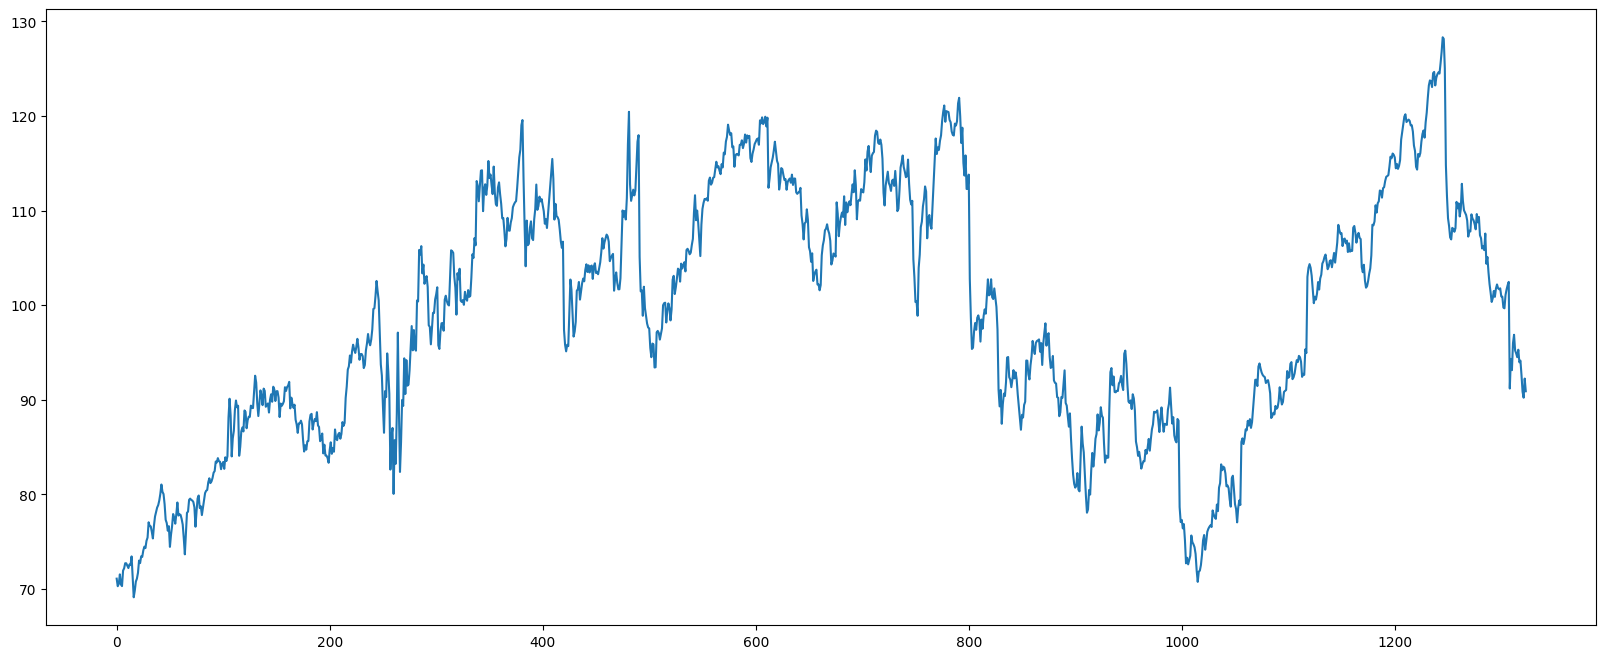

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(df1)
plt.show()

In [10]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df1

array([[0.03327692],
       [0.01976348],
       [0.02415541],
       ...,
       [0.35641887],
       [0.39054043],
       [0.36790536]])

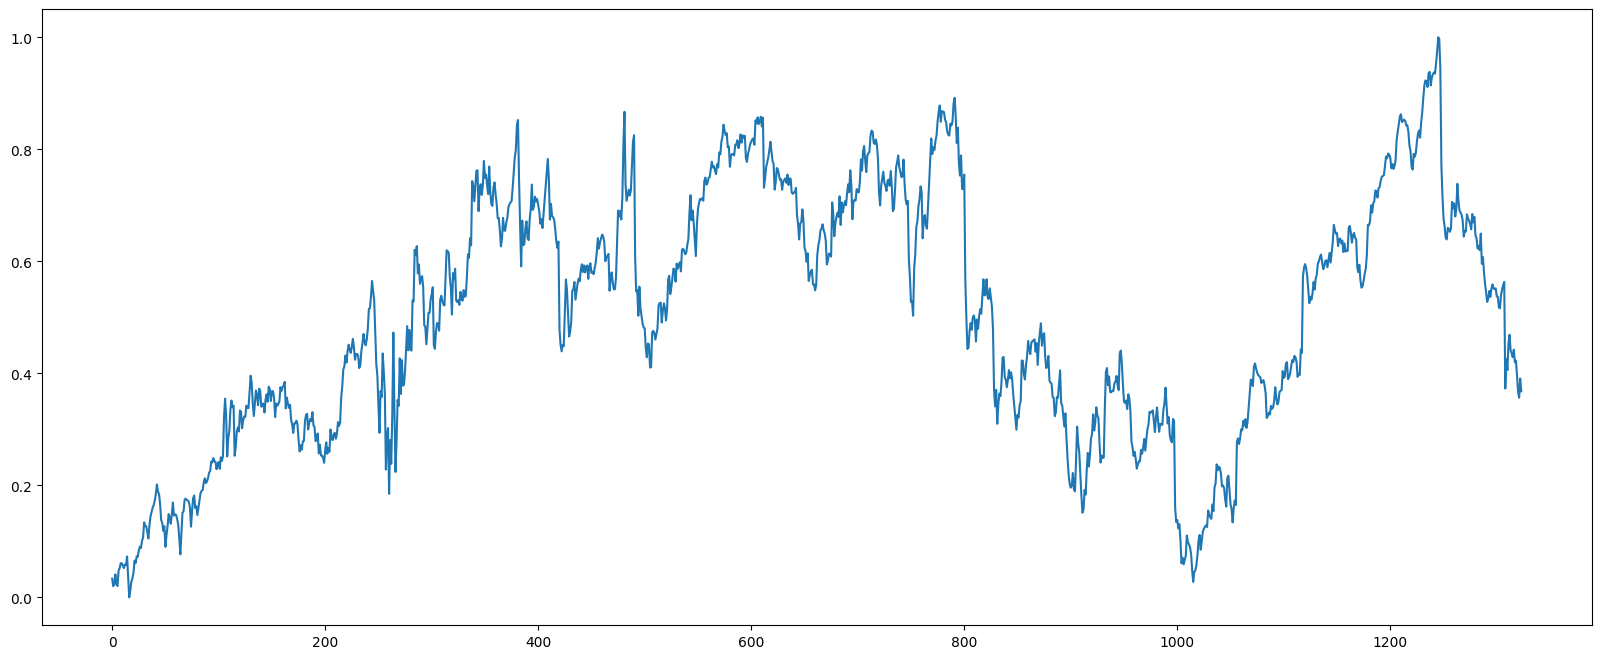

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(df1)
plt.show()

In [13]:
# 4. Chia train test
train_size = int(0.75 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [14]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [17]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 24s 441ms/step - loss: 0.1628 - val_loss: 0.0242
Epoch 2/100
14/14 [==============================] - 1s 105ms/step - loss: 0.0155 - val_loss: 0.0073
Epoch 3/100
14/14 [==============================] - 1s 97ms/step - loss: 0.0085 - val_loss: 0.0105
Epoch 4/100
14/14 [==============================] - 1s 89ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 5/100
14/14 [==============================] - 1s 98ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 6/100
14/14 [==============================] - 2s 127ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 7/100
14/14 [==============================] - 1s 97ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 8/100
14/14 [==============================] - 1s 94ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/100
14/14 [==============================] - 1s 90ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 10/100
14/14 [==============================] - 1s 87ms/step - loss: 0.0023 - val_loss: 0.

In [19]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

8/8 [==============================] - 0s 12ms/step


In [20]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [21]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mape = calculate_mape(ytest, y_pred)
test_mae = calculate_mae(ytest, y_pred)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1.654454239365456
Testing MAPE: 0.987684037151349
Testing MAE: 1.0526171440030567


In [22]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.37486675]
272
1 day input [0.17280397 0.16486476 0.27736481 0.28378368 0.27364858 0.28378368
 0.29983106 0.29814177 0.31503366 0.30658771 0.3180742  0.30253369
 0.31283776 0.33682421 0.362331   0.38834453 0.38851348 0.37719582
 0.4119932  0.41756743 0.40861475 0.40135123 0.39695943 0.39459457
 0.39307424 0.38260122 0.38631746 0.38766884 0.37804047 0.36418912
 0.32010128 0.32331078 0.32956069 0.32652015 0.34172287 0.33665538
 0.33902024 0.35050673 0.37499992 0.35641887 0.34425668 0.34881744
 0.36672293 0.36858105 0.37010126 0.40388504 0.39189181 0.39425666
 0.41689186 0.41993241 0.38952696 0.39290528 0.39999997 0.41300667
 0.42347969 0.42010124 0.43108099 0.42871614 0.42060797 0.39358097
 0.39898637 0.39712825 0.44273644 0.43631744 0.57212825 0.58834445
 0.59493228 0.58834445 0.57415532 0.54999992 0.52516882 0.53682426
 0.53158769 0.54239862 0.56283779 0.54949318 0.56925666 0.57601344
 0.59594588 0.5999999  0.6076012  0.61199312 0.59847969 0.58581077
 0.59037152 0.60067559 0.60185802

In [23]:
# 13. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.37486675]
272
1 day input [0.17280397 0.16486476 0.27736481 0.28378368 0.27364858 0.28378368
 0.29983106 0.29814177 0.31503366 0.30658771 0.3180742  0.30253369
 0.31283776 0.33682421 0.362331   0.38834453 0.38851348 0.37719582
 0.4119932  0.41756743 0.40861475 0.40135123 0.39695943 0.39459457
 0.39307424 0.38260122 0.38631746 0.38766884 0.37804047 0.36418912
 0.32010128 0.32331078 0.32956069 0.32652015 0.34172287 0.33665538
 0.33902024 0.35050673 0.37499992 0.35641887 0.34425668 0.34881744
 0.36672293 0.36858105 0.37010126 0.40388504 0.39189181 0.39425666
 0.41689186 0.41993241 0.38952696 0.39290528 0.39999997 0.41300667
 0.42347969 0.42010124 0.43108099 0.42871614 0.42060797 0.39358097
 0.39898637 0.39712825 0.44273644 0.43631744 0.57212825 0.58834445
 0.59493228 0.58834445 0.57415532 0.54999992 0.52516882 0.53682426
 0.53158769 0.54239862 0.56283779 0.54949318 0.56925666 0.57601344
 0.59594588 0.5999999  0.6076012  0.61199312 0.59847969 0.58581077
 0.59037152 0.60067559 0.60185802

In [24]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.37486675]
272
1 day input [0.17280397 0.16486476 0.27736481 0.28378368 0.27364858 0.28378368
 0.29983106 0.29814177 0.31503366 0.30658771 0.3180742  0.30253369
 0.31283776 0.33682421 0.362331   0.38834453 0.38851348 0.37719582
 0.4119932  0.41756743 0.40861475 0.40135123 0.39695943 0.39459457
 0.39307424 0.38260122 0.38631746 0.38766884 0.37804047 0.36418912
 0.32010128 0.32331078 0.32956069 0.32652015 0.34172287 0.33665538
 0.33902024 0.35050673 0.37499992 0.35641887 0.34425668 0.34881744
 0.36672293 0.36858105 0.37010126 0.40388504 0.39189181 0.39425666
 0.41689186 0.41993241 0.38952696 0.39290528 0.39999997 0.41300667
 0.42347969 0.42010124 0.43108099 0.42871614 0.42060797 0.39358097
 0.39898637 0.39712825 0.44273644 0.43631744 0.57212825 0.58834445
 0.59493228 0.58834445 0.57415532 0.54999992 0.52516882 0.53682426
 0.53158769 0.54239862 0.56283779 0.54949318 0.56925666 0.57601344
 0.59594588 0.5999999  0.6076012  0.61199312 0.59847969 0.58581077
 0.59037152 0.60067559 0.60185802

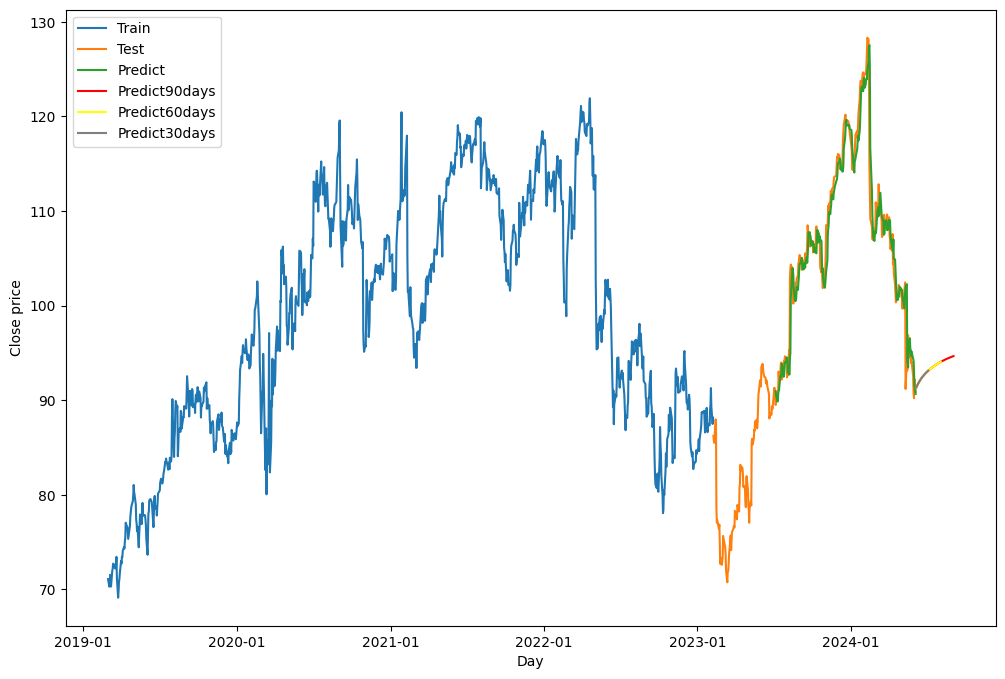

In [25]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(12, 8))
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(df['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:],(y_pred))
predict_data_index_90 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Close price')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

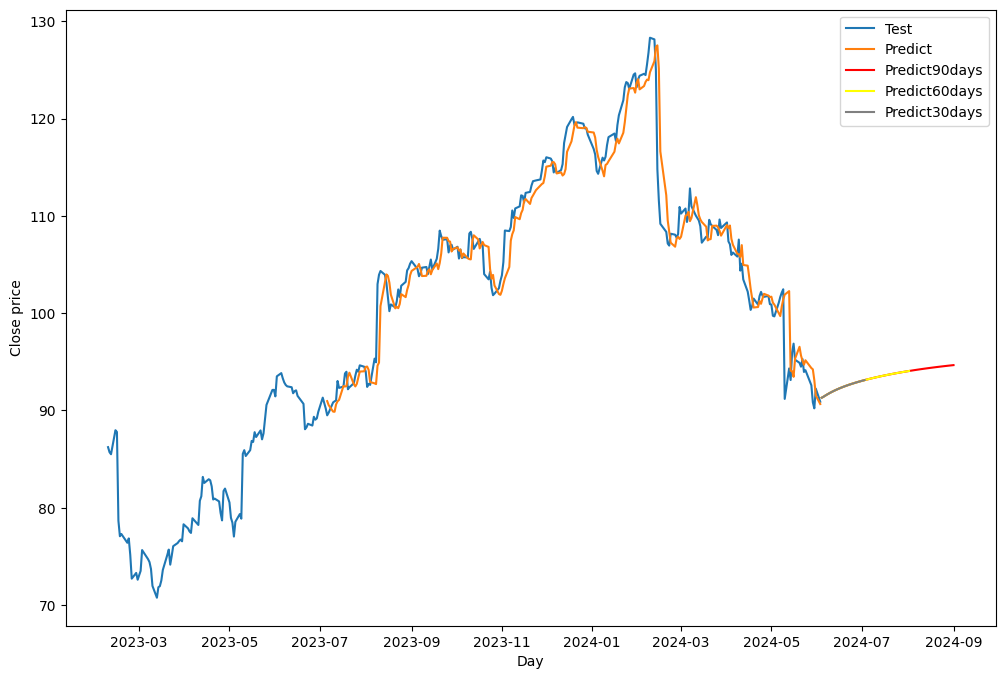

In [26]:
# 14.Vẽ hình test predict
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,8))
plt.plot(df['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:],(y_pred))
predict_data_index_90 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Close price')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

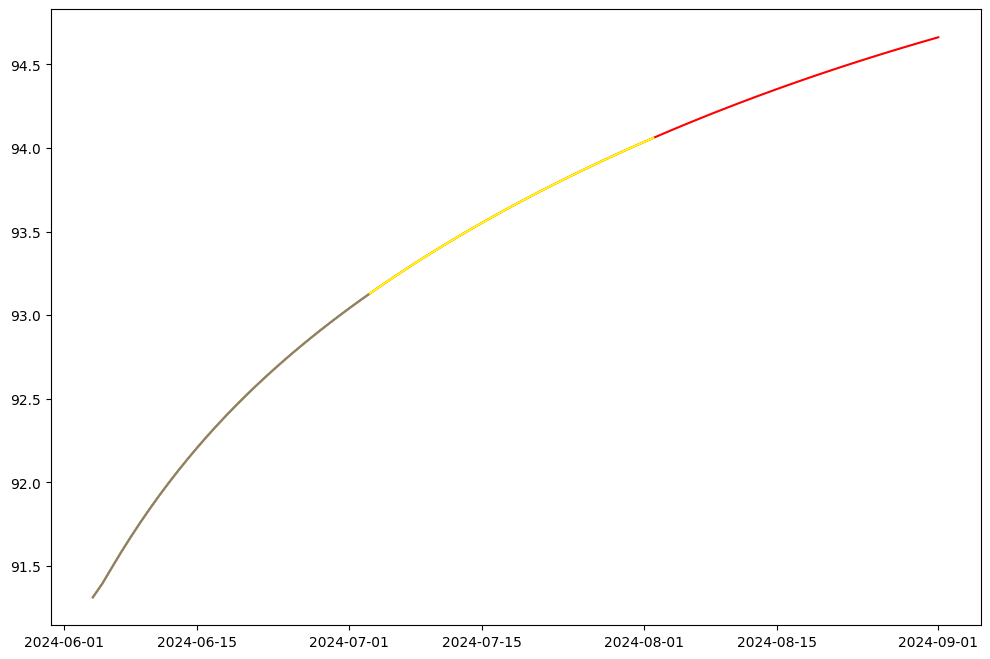

In [27]:
plt.figure(figsize=(12,8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.show()